import libraries

In [34]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import copy
import numpy as np

load the dem file

In [35]:
dem_file = "C:/Users/SAMARTH/Desktop/MTP/mtp/elevation/small_elevation.tif"
with rasterio.open(dem_file) as src:
    elevation_data = src.read(1)

In [ ]:
# with rasterio.open(merged_dem_file) as src:
#     # Get the window of the bounding box
#         window = src.window(*bbox)
#         data = src.read(window=window)

In [36]:
print(np.max(elevation_data))
print("elevation _data shape: ", elevation_data.shape)

1756
elevation _data shape:  (142, 260)


Smoothing the map

In [37]:
elevation_smooth1 = copy.deepcopy(elevation_data)
elevation_smooth2 = copy.deepcopy(elevation_data)
n, m = elevation_data.shape

In [38]:
passes = 1
for cnt in range(passes):
        for i in range(1, n-1):
                for j in range(1, m-1):
                        elevation_smooth1[i][j] = (elevation_smooth2[i-1][j] + elevation_smooth2[i+1][j] + elevation_smooth2[i][j-1] + elevation_smooth2[i][j+1] + elevation_smooth1[i][j])/5
        
        for i in range(1, n-1):
                for j in range(1, m-1):
                        elevation_smooth2[i][j] = (elevation_smooth1[i-1][j] + elevation_smooth1[i+1][j] + elevation_smooth1[i][j-1] + elevation_smooth1[i][j+1] + elevation_smooth1[i][j])/5

Extract the contours from the elevation data

In [39]:
contour_levels = np.arange(100, np.max(elevation_data), 100) # adjust the levels as needed
sorted_contours = contour_levels[::-1]

In [40]:
# add border
def add_border(dummy_array, n, m):
    # right
    for i in range(m):
        dummy_array.append([0, i])
    # down
    for i in range(1, n):
        dummy_array.append([i, m-1])
    # left
    for i in range(m-2, -1, -1):
        dummy_array.append([n-1, i])
    # up
    for i in range(n-2, 0, -1):
        dummy_array.append([i, 0])

In [41]:
contours = []
sorted_contours_levels = []

# add contours
for level in sorted_contours:
    starting = len(contours)
    # print(level, "\n", len(contours))
    contours += measure.find_contours(elevation_data, level)
    ending = len(contours)
    # print(len(contours), "\n----------")
    for i in range(ending-starting):
        sorted_contours_levels.append(level)

In [42]:
# add dummy contour around border
dummy_contour = []
n, m = elevation_data.shape

add_border(dummy_contour, n, m)

sorted_contours_levels.append(0)
contours.append(np.array(dummy_contour))

Show contours

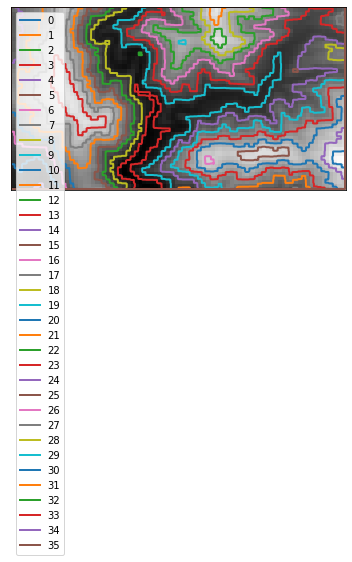

In [43]:
fig, ax = plt.subplots()
ax.imshow(elevation_data, interpolation='nearest', cmap=plt.cm.gray)
for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, label=n) 
ax.axis('image')
plt.legend()
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Marking peaks

In [44]:
def isPeak(elevation_smooth, i, j):
    if ((elevation_smooth[i][j] >= elevation_smooth[i-1][j]) and (elevation_smooth[i][j] >= elevation_smooth[i+1][j]) and (elevation_smooth[i][j] >= elevation_smooth[i][j-1]) and (elevation_smooth[i][j] >= elevation_smooth[i][j+1])):
        if ((elevation_smooth[i][j] >= elevation_smooth[i-1][j-1]) and (elevation_smooth[i][j] >= elevation_smooth[i+1][j+1]) and (elevation_smooth[i][j] >= elevation_smooth[i+1][j-1]) and (elevation_smooth[i][j] >= elevation_smooth[i-1][j+1])):
            # if ((elevation_smooth[i][j] >= elevation_smooth[i-2][j]) and (elevation_smooth[i][j] >= elevation_smooth[i+2][j]) and (elevation_smooth[i][j] >= elevation_smooth[i][j-2]) and (elevation_smooth[i][j] >= elevation_smooth[i][j+2])):
            #if ((elevation_smooth[i][j] >= elevation_smooth[i-2][j]) and (elevation_smooth[i][j] >= elevation_smooth[i+2][j]) and (elevation_smooth[i][j] >= elevation_smooth[i][j-2]) and (elevation_smooth[i][j] >= elevation_smooth[i][j+2])):
            # if not ((elevation_smooth[i][j] == elevation_smooth[i-1][j]) and (elevation_smooth[i][j] == elevation_smooth[i+1][j]) and (elevation_smooth[i][j] == elevation_smooth[i][j-1]) and (elevation_smooth[i][j] == elevation_smooth[i-1][j+1]) and (elevation_smooth[i][j] == elevation_smooth[i+1][j+1]) and (elevation_smooth[i][j] == elevation_smooth[i-1][j-1]) and (elevation_smooth[i][j] == elevation_smooth[i+1][j-1]) and (elevation_smooth[i][j] == elevation_smooth[i-1][j+1])):
                return True
    return False

In [45]:
peaks = []
peaks_lat = []
peaks_lon = []
max_elevation_contour = [0 for i in range(len(contours))]

In [46]:
for i in range(1, elevation_data.shape[0]-1):
    for j in range(1, elevation_data.shape[1]-1):
         if isPeak(elevation_smooth2, i, j):
              peaks.append([i, j])
              peaks_lat.append(i)
              peaks_lon.append(j)
              for k in range(len(contours)):
                   if measure.points_in_poly([(i,j)], contours[k]):
                        max_elevation_contour[k] = max(max_elevation_contour[k], elevation_data[i, j])

Show peaks

peaks:  55
peaks_lat:  55
peaks_lon:  55


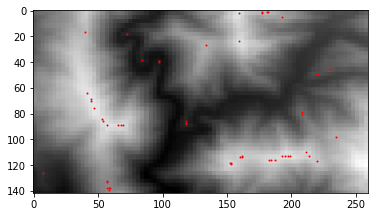

In [47]:
print("peaks: ", len(peaks))
print("peaks_lat: ", len(peaks_lat))
print("peaks_lon: ", len(peaks_lon))
# print(peaks)
plt.imshow(elevation_data, cmap="gray")
plt.scatter(peaks_lon, peaks_lat, color='r',s=1)
plt.show()

get prominences

In [48]:
peak_prominences = [0 for i  in range(len(peaks)) ]
for peak_num in range(len(peaks)):
     for k in range(len(contours)):
            if measure.points_in_poly([peaks[peak_num]], contours[k]):
                 if max_elevation_contour[k] > elevation_data[peaks_lat[peak_num]][peaks_lon[peak_num]]:
                      peak_prominences[peak_num] = elevation_data[peaks_lat[peak_num]][peaks_lon[peak_num]] - sorted_contours_levels[k]
                      break
                 
print(peak_prominences)

[31, 23, 25, 1672, 31, 60, 34, 1077, 162, 105, -35, 1040, 1040, 35, 1201, 1201, 71, 0, 0, 78, 1291, 1291, 48, 50, 1076, 1076, -26, 61, 37, 41, 41, 99, 25, 97, 1652, 49, 49, 48, 12, 94, 97, 34, 34, 31, 78, 15, 15, 116, 1107, 1378, 1378, 1387, 1387, 1386, 1387]


In [50]:
prominent_ones = [[], []]
for i in range(len(peaks)):
    if peak_prominences[i] > 100:
        prominent_ones[0].append(peaks_lat[i])
        prominent_ones[1].append(peaks_lon[i])

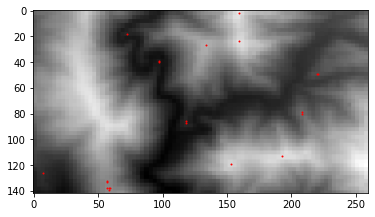

In [51]:
plt.imshow(elevation_data, cmap="gray")
plt.scatter(prominent_ones[1], prominent_ones[0], color='r',s=1)
plt.show()

In [52]:
max_elevation_contour[-1]

1679